In [29]:
from dolfin import *
import numpy as np
import sys as sys
sys.path.append('../src/2D_to_1D/')
import pvs1D_utils as utils
import imp as imp
imp.reload(utils)
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.6, rc={"lines.linewidth": 2.0})


In [41]:
# Get simulation parameters

import json
param_f = open (results_path + 'params.json', "r")
params = json.load(param_f)
param_f.close()

Length = params["Length"]
dt = params["dt"]

microm = 1.0e-3

R1 = params["R1"]*microm
R2 = params["R2"]*microm

T = 2/params["frequency"]
times = np.linspace(0, T, int(T/dt)-1)

In [42]:
# Read meshes

results_path = '../results/results_A2/'

# Read 1d mesh
mesh1D = Mesh()
with XDMFFile(MPI.comm_world, results_path + "pvs1D.xdmf") as xdmf:
    xdmf.read(mesh1D)
    
# Read in the 2D mesh
mesh2D = Mesh()
mesh_fname = "2D%s_L%.0f"%('axi', Length)
ref_meshfile = HDF5File(MPI.comm_world, results_path + "2D/HDF5/mesh.h5", "r")
ref_meshfile.read(mesh2D, "/mesh0", False)
ref_meshfile.close()

In [43]:
## Retrieve solutions and compute averages etc


# Read solutions from 2D and 1D models
V = VectorFunctionSpace(mesh2D, "CG", 2)
V_hat =  FunctionSpace(mesh1D, 'CG', 2)
Q, Q_hat = [FunctionSpace(msh, "CG", 1) for msh in [mesh2D, mesh1D]]

u_2D = Function(V) # Use 2D flux as reference
p_2D = Function(Q) # Same for pressure
w_2D = Function(V)

# Load hdf5 files
u_2D_hfile = HDF5File(MPI.comm_world, results_path + "2D/HDF5/u.h5", "r")
p_2D_hfile = HDF5File(MPI.comm_world, results_path + "2D/HDF5/p.h5", "r")
qhfile =     HDF5File(MPI.comm_world, results_path + "1D/HDF5/q1D.h5", "r")
phfile =     HDF5File(MPI.comm_world, results_path + "1D/HDF5/p1D.h5", "r")
whfile =     HDF5File(MPI.comm_world, results_path + "1D/HDF5/w1D.h5", "r")

# Average 2D flux and pressure
x_coords_V = V_hat.tabulate_dof_coordinates()[:,0]
x_coords_Q = Q_hat.tabulate_dof_coordinates()[:,0]

tol = 1.0e-3
rs = np.linspace(R1+tol, R2-tol, 50)
dr = rs[1]-rs[0]

attr = u_2D_hfile.attributes("/function")
nsteps = attr['count']

q_2D_inflow, q_1D_inflow = [], []

q_2D_p1, q_1D_p1 = [], []

q_2Ds, q_1Ds = [], []

p_2Ds, p1Ds, ws =  [], [], []

R_m = 0.5*(R1 + R2)

print('Nsteps', nsteps)
for i in range(0, nsteps-1):
    q1D = Function(V_hat)
    p1D = Function(Q_hat)
    w1D = Function(Q_hat)

    dataset = "/function/vector_%d"%i
    dataset2D = "/function/vector_%d"%(i)
    attr2D = u_2D_hfile.attributes(dataset2D)
    attr = u_2D_hfile.attributes(dataset)
    u_2D_hfile.read(u_2D, dataset2D)
    p_2D_hfile.read(p_2D, dataset2D)
    qhfile.read(q1D, dataset)
    phfile.read(p1D, dataset)
    whfile.read(w1D, dataset)
    
    q_1Ds.append(q1D)
    p1Ds.append(p1D)
    
    ## For comparison: Plot cross section fluxes obtained from 1D and 2D model
    
    # We find cross section flux q from 2D model via quadrature over cross section
    A_pv = np.pi*(R2**2.0-R1**2.0)
    q_2D_vals = [(2.0*np.pi)*np.sum([u_2D(s, r)[0]*r*dr for r in rs]) for s in x_coords_V]
    p_2D_avg_vals = [(2.0*np.pi)/(A_pv)*np.sum([p_2D(s, r)*r*dr for r in rs]) for s in x_coords_Q]
    w_2D_avg_vals = [(2.0*np.pi)/(A_pv)*np.sum([w_2D(s, r)*r*dr for r in rs]) for s in x_coords_Q]

    q_2D = Function(q1D.function_space())
    q_2D.vector()[:] = q_2D_vals
    q_2Ds.append(q_2D)
    
    p_2D_avg = Function(p1D.function_space())
    p_2D_avg.vector()[:] = p_2D_avg_vals
    p_2Ds.append(p_2D_avg)
    
    # Make list of q at inlet for 2D and 1D model
    q_2D_inflow.append(q_2D(0.0, R_m, 0.0))
    q_1D_inflow.append(q1D(0.0, R_m, 0.0))

    q_2D_p1.append(q_2D(0.12, R_m, 0.0))
    q_1D_p1.append(q1D(0.12, R_m, 0.0))

    ws.append( w1D(0.0, R_m, 0.0) )

Nsteps 40


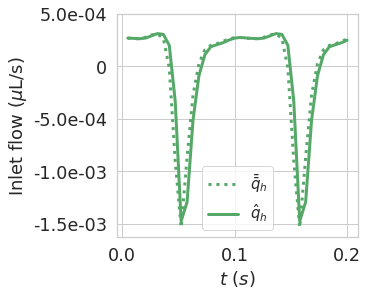

In [44]:

fig_q, axs_q = plt.subplots(1, 1, constrained_layout = True, figsize=(5,4))
sns.set_context("notebook", font_scale=1.6, rc={"lines.linewidth": 3.0})


# Plot q from 2D and 1D solutions as a function of time
q_2D_inflow_nu = np.asarray(q_2D_inflow)
q_1D_inflow_nu = np.asarray(q_1D_inflow)

axs_q.plot( times[1:], q_2D_inflow_nu[1:], 'g:', label='$\\bar{\\bar{q}}_h$')
axs_q.plot( times[1:], q_1D_inflow_nu[0:-1], 'g', label='$\hat{q}_h$')

# Specify y ticks
yticks = [-0.0015, -0.001, -0.0005, 0, 0.0005]
ytick_labels = [f'{y:1.1e}' for y in yticks  ]
ytick_labels[3] = '0'

axs_q.set_yticks(yticks)
axs_q.set_yticklabels(ytick_labels)


# Specify x ticks
xticks = [0.0, 0.1, 0.2]
xtick_labels = [f'{x}' for x in xticks  ]

axs_q.set_xticks(xticks)
axs_q.set_xticklabels(xtick_labels)

axs_q.set_xlabel('$t \,\,(s)$', fontsize=18)
axs_q.set_ylabel('Inlet flow ($\mu$L/s)', fontsize=18)

plt.legend(fontsize=15)
fig_q.savefig('/home/ingeborg/Desktop/A2-q-green.png')

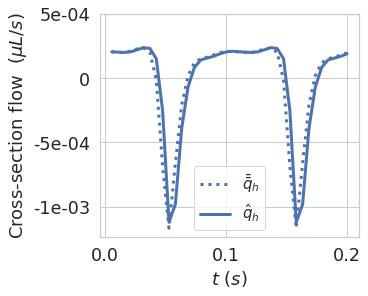

In [45]:

fig_q, axs_q = plt.subplots(1, 1, constrained_layout = True, figsize=(5,4))
sns.set_context("notebook", font_scale=1.6, rc={"lines.linewidth": 3.0})


# Plot q from 2D and 1D solutions as a function of time
q_2D_p1_nu = np.asarray(q_2D_p1)
q_1D_p1_nu = np.asarray(q_1D_p1)

axs_q.plot( times[1:], q_2D_p1_nu[1:], 'b:', label='$\\bar{\\bar{q}}_h$')
axs_q.plot( times[1:], q_1D_p1_nu[0:-1], 'b', label='$\hat{q}_h$')



# Specify y ticks
yticks = [-0.001, -0.0005, 0, 0.0005]
ytick_labels = [f'{y:1.0e}' for y in yticks  ]
ytick_labels[2] = '0'

axs_q.set_yticks(yticks)
axs_q.set_yticklabels(ytick_labels)


# Specify x ticks
xticks = [0.0, 0.1, 0.2]
xtick_labels = [f'{x}' for x in xticks  ]

axs_q.set_xticks(xticks)
axs_q.set_xticklabels(xtick_labels)

axs_q.set_xlabel('$t \,\,(s)$', fontsize=18)
axs_q.set_ylabel('Cross-section flow $ \,\, (\mu L/s)$', fontsize=18)

plt.legend(fontsize=15)

fig_q.savefig('/home/ingeborg/Desktop/A2-q-blue.png')